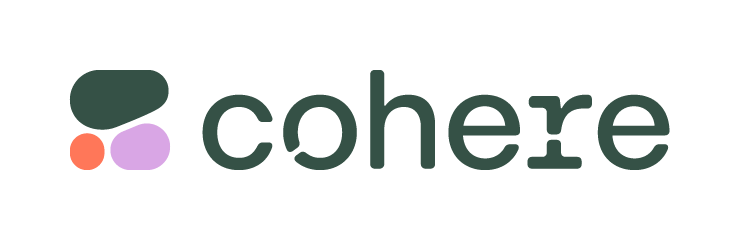

# Evaluating summarization

In this cookbook, we will be demonstrating an approach we use for evaluating summarization tasks using LLM evaluation.

### Table of contents:
1. [Get started](#start)
2. [Construct the evaluation dataset](#dataset)
3. [Build the evaluation framework](#eval-framework)
5. [Run evaluations](#run-evals)

<a id="start"></a>
<a name="start"></a>
# Get Started

You'll need a Cohere API key to run this notebook. If you don't have a key, head to https://cohere.com/ to generate your key.

In [57]:
# %%capture
#!pip install "cohere<5" datasets --quiet

In [58]:
import json
import random
import re
import os
from typing import List, Optional

import cohere
from getpass import getpass
from datasets import load_dataset
import pandas as pd
from dotenv import load_dotenv

# Set up Cohere client
load_dotenv()

co_model = "command-r"
co = cohere.Client(api_key=os.getenv('COHERE_API_KEY'))

As test data, we'll use transcripts from the [QMSum dataset](https://github.com/Yale-LILY/QMSum). Note that in addition to the transcripts, this dataset also contains reference summaries -- we will use only the transcripts as our approach is reference-free.

In [59]:
qmsum = load_dataset("MocktaiLEngineer/qmsum-processed", split="validation")
transcripts = [x for x in qmsum["meeting_transcript"] if x is not None]

In [60]:
transcripts[0]

'PhD D: Sure because I I need a lot of time to to put the label or to do that \nProfessor E: I mean we we know that there s noise There s there s continual noise from fans and so forth and there is more impulsive noise from taps and so forth and and something in between with paper rustling We know that all that s there and it s a g worthwhile thing to study but obviously it takes a lot of time to mark all of these things Whereas th i I would think that you we can study more or less as a distinct phenomenon the overlapping of people talking So Then you can get the Cuz you need If it s three hundred i i it sounds like you probably only have fifty or sixty or seventy events right now that are really And and you need to have a lot more than that to have any kind of even visual sense of of what s going on much less any kind of reasonable statistics \nPhD C: Now why do you need to mark speaker overlap by hand if you can infer it from the relative energy in the \nGrad G: Well that s That s wh

<a id="dataset"></a>
<a name="dataset"></a>
# Construct the evaluation dataset

We are interested in evaluating summarization in real-world, enterprise use cases, which typically have two distinguishing features as compared to academic summarization benchmarks:
- Enterprise use cases often focus on specific summarization objectives, e.g. "summarize action items".
- Enterprise use cases often feature specific instruction constraints, e.g. "summarize in bullets with each bullet under 20 words".

Therefore, we must first create a dataset that contains diverse summarization prompts. We will do this programmatically by building prompts from their components, as defined below:
- Prompt = text (e.g. transcript to be summarized) + instruction
- Instruction = instruction objective (e.g. "summarize action items") + modifiers
- Modifiers = format/length modifiers (e.g. "use bullets") + style/tone modifiers (e.g. "do not mention names") + ...

First, we define the prompt that combines the text and instructions. Here, we use a very basic prompt:

In [61]:
prompt_template = """## meeting transcript
{transcript}

## instructions
{instructions}"""

Next, we build the instructions. Because each instruction may have a different objective and modifiers, we track them using metadata. This will later be required for evaluation (i.e. to know what the prompt is asking).

In [ ]:
# In this cookbook, we will only consider the following 2 objectives and 4 format/length modifiers

instruction_objectives = {
    "general_summarization": "Summarize the meeting based on the transcript.",
    "action_items": "What are the follow-up items based on the meeting transcript?",
}

# Note that not all format/length modifiers are compatible with all objectives. For example, action
# items are best suited for bullet format.
format_length_modifiers = {
    "paragraphs_short": {
        "text": "In paragraph form, output your response. Use at least 10 words and at most 50 words in total.",
        "objectives": ["general_summarization"],
        "eval_metadata": {
            "format": "paragraphs",
            "min_length": 10,
            "max_length": 50,
        },
    },
    "paragraphs_medium": {
        "text": "Return the answer in the form of paragraphs. Make sure your answer is between 50 and 200 words long.",
        "objectives": ["general_summarization"],
        "eval_metadata": {
            "format": "paragraphs",
            "min_length": 50,
            "max_length": 200,
        },
    },
    "bullets_short_3": {
        "text": "Format your answer in the form of bullets. Use exactly 3 bullets. Each bullet should be at least 10 words and at most 20 words.",
        "objectives": ["general_summarization", "action_items"],
        "eval_metadata": {
            "format": "bullets",
            "number": 3,
            "min_length": 10,
            "max_length": 20,
        },
    },
    "bullets_medium_2": {
        "text": "In bullets, output your response. Make sure to use exactly 2 bullets. Make sure each bullet is between 20 and 80 words long.",
        "objectives": ["general_summarization", "action_items"],
        "eval_metadata": {
            "format": "bullets",
            "number": 2,
            "min_length": 20,
            "max_length": 80,
        },
    },
}

Let's combine the objectives and format/length modifiers to finish building the instructions.

In [62]:
instructions = []
for obj_name, obj_text in instruction_objectives.items():
    for mod_data in format_length_modifiers.values():
        for mod_obj in mod_data["objectives"]:
            if mod_obj == obj_name:
                instruction = {
                        "instruction": f"{obj_text} {mod_data['text']}",
                        "eval_metadata": mod_data["eval_metadata"],
                        "objective": obj_name,
                    }
                instructions.append(instruction)

# View the first two instructions
print(json.dumps(instructions[:2], indent=4))

[
    {
        "instruction": "Summarize the meeting based on the transcript. In paragraph form, output your response. Use at least 10 words and at most 50 words in total.",
        "eval_metadata": {
            "format": "paragraphs",
            "min_length": 10,
            "max_length": 50
        },
        "objective": "general_summarization"
    },
    {
        "instruction": "Summarize the meeting based on the transcript. Return the answer in the form of paragraphs. Make sure your answer is between 50 and 200 words long.",
        "eval_metadata": {
            "format": "paragraphs",
            "min_length": 50,
            "max_length": 200
        },
        "objective": "general_summarization"
    }
]


Finally, let's build the final prompts by semi-randomly pairing the instructions with transcripts from the QMSum dataset.

In [63]:
instructions

[{'instruction': 'Summarize the meeting based on the transcript. In paragraph form, output your response. Use at least 10 words and at most 50 words in total.',
  'eval_metadata': {'format': 'paragraphs',
   'min_length': 10,
   'max_length': 50},
  'objective': 'general_summarization'},
 {'instruction': 'Summarize the meeting based on the transcript. Return the answer in the form of paragraphs. Make sure your answer is between 50 and 200 words long.',
  'eval_metadata': {'format': 'paragraphs',
   'min_length': 50,
   'max_length': 200},
  'objective': 'general_summarization'},
 {'instruction': 'Summarize the meeting based on the transcript. Format your answer in the form of bullets. Use exactly 3 bullets. Each bullet should be at least 10 words and at most 20 words.',
  'eval_metadata': {'format': 'bullets',
   'number': 3,
   'min_length': 10,
   'max_length': 20},
  'objective': 'general_summarization'},
 {'instruction': 'Summarize the meeting based on the transcript. In bullets, o

In [ ]:
data = pd.DataFrame(instructions)

# Randomly shuffle the top 25% of transcripts by length, then assign them to the data
transcripts = sorted(transcripts, key=lambda x: len(x), reverse=True)[:int(len(transcripts) * 0.25)]
random.seed(42)
random.shuffle(transcripts)
data["transcript"] = transcripts[:len(data)]

# Build the prompt
data["prompt"] = data.apply(lambda x: prompt_template.format(transcript=x["transcript"], instructions=x["instruction"]), axis=1)

In [ ]:
#transcripts[:len(data)]

In [64]:
data.iloc[0]['transcript']

'PhD F: As opposed to the rest of us \nPhD D: Well comment OK I I remind that me my first objective eh in the project is to to study difference parameters to to find a a good solution to detect eh the overlapping zone in eh speech recorded But eh tsk comment ehhh comment In that way comment I I I begin to to study and to analyze the ehn the recorded speech eh the different session to to find and to locate and to mark eh the the different overlapping zone And eh so eh I was eh I am transcribing the the first session and I I have found eh eh one thousand acoustic events eh besides the overlapping zones eh I I I mean the eh breaths eh aspiration eh eh talk eh eh clap eh comment I do not know what is the different names eh you use to to name the the pause n speech \nGrad G: Oh I do not think we ve been doing it at that level of detail So \nPhD D: Eh I I I do I do not need to to to mmm to m to label the the different acoustic but I prefer because eh I would like to to study if eh I I will f

In [65]:
# (Optional) Let's also check the token lengths of our prompts.
data["transcript_token_len"] = [len(x) for x in co.batch_tokenize(data["transcript"].tolist(), model=co_model)]

In [ ]:
# Let's examine one of the prompts
#print(data["prompt"][0])

<a id="eval-framework"></a>
<a name="eval-framework"></a>
# Build the evaluation framework

We now setup the tools we will use for evaluation.

We use three criteria that are graded using LLMs:
- Completeness: checks if the summary includes all the important information from the original text that it should include
- Correctness: checks if there are any hallucinations or factual inaccuracies in the summary
- Conciseness: checks if the summary includes any unnecessary information or wordiness

In this cookbook, we will use Command-R to grade the completions. However, note that in practice, we typically use an ensemble of multiple LLM evaluators to reduce any bias.

In [66]:
# LLM evaluation uses an LLM to grade the completion. We pass the original prompt, completion, and a
# criteria to the LLM, and it returns a score between 1 and 5. We will use the following template as
# the grading prompt.

grading_prompt_template = """You are an AI grader that given a prompt, a completion, and a criterion, grades the completion based on the prompt and criterion. Below is a prompt, a completion, and a criterion with which to grade the completion. You need to respond according to the criterion instructions.

PROMPT:
{prompt}

COMPLETION:
{completion}

CRITERION:
{criteria}

Do not provide an explanation or respond with additional text. Only respond with the final score in the format SCORE: <final_score>

SCORE:"""


criteria_completeness = """Please judge the above completion on whether or not all the completion fully addresses the task posed in the prompt. The completion should contain all the information that is asked for by the prompt while also upholding the constraints mentioned in the prompt. Please return a grade between 1 and 5, where 1 means the completion does not address the prompt at all, 2 means the completion mostly does not address the prompt, 3 is neutral, 4 means the completion mostly addresses the prompt, and 5 means the completion fully addresses the prompt."""

criteria_correctness = """Please judge the above completion on whether or not all information was derived from the prompt and that no information is false. Return a grade between 1 and 5, where 1 means the answers are entirely untruthful relative to the prompt, 2 means the answers are somewhat untruthful relative to the prompt, 3 means neutral, 4 means the answers are somewhat truthful relative to the prompt, and 5 means the answers are entirely truthful relative to the prompt. Evaluate only the truthfulness of the answers, not whether or not they capture all the relevant information in the prompt."""

criteria_conciseness = """Please judge the above completion on whether or not the completion contains any unnecessary information or wordiness that does not help answer the specific instruction given in the prompt. Return a grade between 1 and 5, where 1 means the completion contains many unnecessary details and wordiness that do not answer the specific instruction given in the prompt, 2 means the completion contains some unnecessary details or wordiness, 3 means neutral, 4 means the completion contains few unnecessary details or wordiness, and 5 means the completion contains only necessary details that answer the specific instruction given in the prompt."""


def score_llm(prompt: str, completion: str, criteria: str) -> int:
    """
    Score a completion based on a prompt and a criterion using LLM Because we
    grade all completions on a scale of 1-5, we will normalize the scores by 5 so that the final score
    is between 0 and 1.
    """
    grading_prompt = grading_prompt_template.format(
        prompt=prompt, completion=completion, criteria=criteria
    )
    # Use Cohere to grade the completion
    completion = co.chat(message=grading_prompt, model=co_model, temperature=0.2).text

    ### Alternatively, use OpenAI to grade the completion (requires key)
    # import openai
    # completion = openai.OpenAI(api_key="INSERT OPENAI KEY HERE").chat.completions.create(
    #     model="gpt-4",
    #     messages=[{"role": "user", "content": grading_prompt}],
    #     temperature=0.2,
    # ).choices[0].message.content

    # Extract the score from the completion
    score = float(re.search(r"[12345]", completion).group()) / 5
    return score

In addition, we have two criteria that are graded programmatically:
- Format: checks if the summary follows the format (e.g. bullets) that was requested in the prompt
- Length: checks if the summary follows the length that was requested in the prompt.

In [67]:
# Non-LLM checks

def score_format(completion: str, format_type: str) -> int:
    """
    Returns 1 if the completion is in the correct format, 0 otherwise.
    """
    if format_type == "paragraphs":
        return int(_is_only_paragraphs(completion))
    elif format_type == "bullets":
        return int(_is_only_bullets(completion))
    return 0

def score_length(
    completion: str,
    format_type: str,
    min_val: int,
    max_val: int,
    number: Optional[int] = None
) -> int:
    """
    Returns 1 if the completion has the correct length for the given format, 0 otherwise. This
    includes both word count and number of items (optional).
    """
    # Split into items (each bullet for bullets or each paragraph for paragraphs)
    if format_type == "bullets":
        items = _extract_markdown_bullets(completion, include_bullet=False)
    elif format_type == "paragraphs":
        items = completion.split("\n")

    # Strip whitespace and remove empty items
    items = [item for item in items if item.strip() != ""]

    # Check number of items if provided
    if number is not None and len(items) != number:
        return 0

    # Check length of each item
    for item in items:
        num_words = item.strip().split()
        if min_val is None and len(num_words) > max_val:
            return 0
        elif max_val is None and len(num_words) < min_val:
            return 0
        elif not min_val <= len(num_words) <= max_val:
            return 0
    return 1


def _is_only_bullets(text: str) -> bool:
    """
    Returns True if text is only markdown bullets.
    """
    bullets = _extract_markdown_bullets(text, include_bullet=True)

    for bullet in bullets:
        text = text.replace(bullet, "")

    return text.strip() == ""


def _is_only_paragraphs(text: str) -> bool:
    """
    Returns True if text is only paragraphs (no bullets).
    """
    bullets = _extract_markdown_bullets(text, include_bullet=True)

    return len(bullets) == 0


def _extract_markdown_bullets(text: str, include_bullet: bool = False) -> List[str]:
    """
    Extracts markdown bullets from text as a list. If include_bullet is True, the bullet will be
    included in the output. The list of accepted bullets is: -, *, +, •, and any number followed by
    a period.
    """
    if include_bullet:
        return re.findall(r"^[ \t]*(?:[-*+•]|[\d]+\.).*\w+.*$", text, flags=re.MULTILINE)
    return re.findall(r"^[ \t]*(?:[-*+•]|[\d]+\.)(.*\w+.*)$", text, flags=re.MULTILINE)


<a id="run-evals"></a>
<a name="run-evals"></a>
# Run evaluations

Now that we have our evaluation dataset and defined our evaluation functions, let's run evaluations!

First, we generate completions to be graded. We will use Cohere's [Command-R](https://huggingface.co/CohereForAI/c4ai-command-r-v01) model, boasting a context length of 128K.

In [ ]:
#data["prompt"]

In [68]:
print(data["prompt"][0])

## meeting transcript
PhD F: As opposed to the rest of us 
PhD D: Well comment OK I I remind that me my first objective eh in the project is to to study difference parameters to to find a a good solution to detect eh the overlapping zone in eh speech recorded But eh tsk comment ehhh comment In that way comment I I I begin to to study and to analyze the ehn the recorded speech eh the different session to to find and to locate and to mark eh the the different overlapping zone And eh so eh I was eh I am transcribing the the first session and I I have found eh eh one thousand acoustic events eh besides the overlapping zones eh I I I mean the eh breaths eh aspiration eh eh talk eh eh clap eh comment I do not know what is the different names eh you use to to name the the pause n speech 
Grad G: Oh I do not think we ve been doing it at that level of detail So 
PhD D: Eh I I I do I do not need to to to mmm to m to label the the different acoustic but I prefer because eh I would like to to stud

In [ ]:
# completions = []
# for prompt in data["prompt"]:
#     completion = co.chat(message=prompt, model="command-r", temperature=0.2).text
#     completions.append(completion)

# data["completion"] = completions

In [69]:
completion = co.chat(message=data['prompt'][0], model="command-r", temperature=0.2).text
completion

'PhD D is transcribing recorded sessions to find and label overlapping speech zones. Other team members question their definition of an event, suggesting thousands of events in a short time is excessive. PhD D maintains their approach is valid.'

In [ ]:
#data.head()

Let's grade the completions using our LLM and non-LLM checks.

In [70]:
### Score Format
score_format(completion, data["eval_metadata"][0]['format'])

1

In [71]:
### Score Length
score_length(
        completion,
        data["eval_metadata"][0]["format"],
        data["eval_metadata"][0]["min_length"],
        data["eval_metadata"][0]["max_length"],
    )

1

In [72]:
data['eval_metadata'][0]['min_length']

10

In [73]:
# Score completeness
score_llm(data["prompt"][0], completion, criteria_completeness)


0.8

In [74]:
# # Score correctness
score_llm(data["prompt"][0], completion, criteria_correctness)

1.0

In [75]:
# # Score conciseness
score_llm(data["prompt"][0], completion, criteria_conciseness)

0.8

In [ ]:
# # Score format
# data["format_score"] = data.apply(
#     lambda x: score_format(x["completion"], x["eval_metadata"]["format"]), axis=1
# )

# # Score length
# data["length_score"] = data.apply(
#     lambda x: score_length(
#         x["completion"],
#         x["eval_metadata"]["format"],
#         x["eval_metadata"].get("min_length"),
#         x["eval_metadata"].get("max_length"),
#     ),
#     axis=1,
# )

# # Score completeness
# data["completeness_score"] = data.apply(
#     lambda x: score_llm(x["prompt"], x["completion"], criteria_completeness), axis=1
# )

# # Score correctness
# data["correctness_score"] = data.apply(
#     lambda x: score_llm(x["prompt"], x["completion"], criteria_correctness), axis=1
# )

# # Score conciseness
# data["conciseness_score"] = data.apply(
#     lambda x: score_llm(x["prompt"], x["completion"], criteria_conciseness), axis=1
# )

In [ ]:
# Let's examine the final evaluation results
#data

Finally, let's plot the average scores per critiera.

In [ ]:
# avg_scores = data[["format_score", "length_score", "completeness_score", "correctness_score", "conciseness_score"]].mean()
# ax = avg_scores.plot.bar(title="Average Scores", xlabel="Criteria", ylabel="Score")